In [2]:
import os
import pydiffvg
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import warp
from skimage import transform as tf
import imageio 
import matplotlib.font_manager as font_manager
import sys 
import torch
import torch.nn as nn
from torchvision import models, transforms
import PIL
from skimage.transform import resize
import torch.nn.functional as F
import matplotlib.cm as cm
import shutil


p = os.path.abspath('..')
sys.path.insert(1, p)
import sketch_utils as utils
from U2Net_.model import U2NET
from scipy import ndimage
from torchvision.utils import make_grid
from scipy.optimize import curve_fit

import notebooks_utils

device = torch.device("cuda:0" if (
            torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")

path_to_initial_sketches = "/home/vinker/dev/background_project/experiements/all_together_09_09/" # to result sketches of the semantic simplification (first row) 
path_to_files = "/home/vinker/dev/input_images/background_sketching/" # to input images

In [3]:
def ratios_to_str(ratios):
    ratios_str = ""
    for r_ in ratios:
        r_str = f"{r_:.3f}"
        ratios_str += f"{float(r_str)},"
    ratios_str = ratios_str[:-1]
    return ratios_str

def get_clip_loss(path, layer, object_or_background):
    path_config = f"{path}/config.npy"
    config = np.load(path_config, allow_pickle=True)[()]
    loss_clip = np.array(config[f"loss_eval"])
    best_iter = np.argsort(loss_clip)[0]
    loss_clip_layer = np.array(config[f"clip_vit_l{layer}_original_eval"])
    if object_or_background == "object":
        loss_clip_layer4 = np.array(config[f"clip_vit_l4_original_eval"])
        loss_clip_layer = 1*loss_clip_layer4 + loss_clip_layer
    return best_iter, loss_clip_layer

def func(x, a, c, d):
    return a*np.exp(c*x)

def func_inv(y,a,c,d):
    return np.log(y / a) * (1 / c)

def get_func(ratios_rel, start_x, start_ys):
    target_ys = ratios_rel[start_ys:]
    x = np.linspace(start_x, start_x + len(target_ys) - 1, len(target_ys))
    # calculate polynomial
    popt, pcov = curve_fit(func, x, target_ys, maxfev=3000)
    return popt

def get_ratios_str(path_to_initial_sketches, rel_layer, folder_name_rel, folder_name_l, layer, ratios_rel, im_name, object_or_background, min_div, prevseed=False):        
    # fit an exponent to ratios_rel (ratios of the relative layer)
    start_ys, start_x, end_x_addition = 0, 0, 0
    popt = get_func(ratios_rel, start_x, start_ys)
    if object_or_background == "object":
        start_x = -2
    if object_or_background == "background":
        start_x = -1
    
    svg_filename = notebooks_utils.get_svg_path(f"{path_to_initial_sketches}/{folder_name_l}")
    seed = notebooks_utils.get_seed(svg_filename)
    # print(svg_filename, "seed", seed)
    path_li = f"{path_to_initial_sketches}/{folder_name_l}/{folder_name_l}_seed{seed}"
    best_iter, loss_clip_layer = get_clip_loss(path_li, layer, object_or_background)
    best_lclip_layer = loss_clip_layer[best_iter]
    # print("best_iter", best_iter, "best_lclip_layer", best_lclip_layer)
    
    # getting the scaling factor among different layers of CLIP
    if not prevseed:
        svg_filename = notebooks_utils.get_svg_path(f"{path_to_initial_sketches}/{folder_name_rel}")
        seed = notebooks_utils.get_seed(svg_filename)
        # ========== fix this bug
    
    # print(svg_filename, "seed", seed)
    path_l_rel = f"{path_to_initial_sketches}/{folder_name_rel}/{folder_name_rel}_seed{seed}"
    best_iter_rel, loss_clip_layer_rel = get_clip_loss(path_l_rel, rel_layer, object_or_background)
    best_lclip_layer_rel = loss_clip_layer_rel[best_iter_rel]
    # print("best_iter_rel", best_iter_rel, "best_lclip_layer_rel", best_lclip_layer_rel)
    
    div1 = best_lclip_layer / best_lclip_layer_rel 
    
    # get the first value in the relative layer, sampled from the new function
    step_size = 1
    num_steps = len(ratios_rel) - start_x
    start_ = start_x
    end = len(ratios_rel)
    x_new_ = np.linspace(start_, end - step_size, num_steps)
    y_new_ = func(x_new_, *popt)
    scale_layer = y_new_[0] / div1
    x_value = func_inv([scale_layer], *popt)
    
    
    div = min(div1, 1.8) # only relevant for layer 11, where the jump is too high 
    if min_div:
        div = max(div1, min_div) # only relevant for layer 11, where the jump is too high 
    # print(f"layer[{layer}] org_div[{div1:.3f}] div[{div:.3f}]")
    step_size = div
    num_steps = len(ratios_rel) - start_x + end_x_addition
    start_ = x_value[0]
    end = num_steps * step_size
    # sample the function from the initial scaled r_1 with the corresponding step size
    new_xs_layer_l = np.linspace(start_, end - step_size + start_, num_steps) 
    # print("new_xs_layer_l", new_xs_layer_l)
    ratios_li = func(new_xs_layer_l, *popt)
    ratios_str = ratios_to_str(ratios_li)

    return ratios_str

def get_ratios_srt2(path_to_initial_sketches, folder_name_l, layer, im_name, object_or_background, step_size_l, num_ratios=8):
    # get the sketch of the given layer, and get L_clip_i 
    #bklla
    svg_filename = notebooks_utils.get_svg_path(f"{path_to_initial_sketches}/{folder_name_l}")
    seed = notebooks_utils.get_seed(svg_filename)
    path_li = f"{path_to_initial_sketches}/{folder_name_l}/{folder_name_l}_seed{seed}"
    best_iter, loss_clip_layer = get_clip_loss(path_li, layer, object_or_background)
    best_lclip_layer = loss_clip_layer[best_iter]
    r_1_k = 1 / best_lclip_layer
    
    # get the next ratios by jumping by 2
    r_j_k = r_1_k
    ratios_k = [r_1_k]
    for j in range(4):
        r_j_k = r_j_k / 2
        ratios_k.append(r_j_k)
    start_ys, start_x, end_x_addition = 0, 0, 0
    popt = get_func(ratios_k, start_x=0, start_ys=0) # fit the function to ratios_k
    x_1_k = func_inv([r_1_k], *popt)

    step_size = step_size_l
    num_steps = num_ratios - start_x + end_x_addition
    start_ = x_1_k[0]
    end = num_steps * step_size
    # sample the function from the initial scaled r_1 with the corresponding step size
    new_xs_layer_l = np.linspace(start_, end - step_size + start_, num_steps) 
    # print("new_xs_layer_l", new_xs_layer_l)
    ratios_li = func(new_xs_layer_l, *popt)
    ratios_str = ratios_to_str(ratios_li)
    xs_layer_l_str = ratios_to_str(new_xs_layer_l)
    # print(f"layer {layer} r_1_k {r_1_k} \n new {ratios_str} \n x {xs_layer_l_str}\n")
    return ratios_str


In [4]:
def init_dict(layers):
    d = {}
    for l in layers:
        d[l] = {}
    return d

def draw_graph(ys, layer, i, colors, ylabel, xlabel, title, label=None, x_vals=None):
    
    if x_vals is None:
        x_vals = range(len(ys))
        plt.plot(x_vals, ys, c=np.array([colors[i]]))
    if label is None:
        label = f"layer {layer}"
        
    plt.scatter(x_vals, ys, label=label, s=20, c=np.array([colors[i]]))
    for k in range(len(ys)):
        if x_vals is None:
            plt.annotate("{:.2f}".format(ys[k]), (x_vals[k], ys[k]), fontsize=10)
        else:
            plt.annotate("{:.0f}".format(k), (x_vals[k], ys[k]), fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    plt.xlabel(xlabel, fontsize=10)
    plt.title(title)
    plt.legend()

def draw_matrix_and_graphs(object_or_background, images, layers, path_to_res, rel_layer, ratios_rel, divs, step=1, resize_obj=0):
    final_ratio_per_l_per_im, final_num_s_per_l_per_im, ratios_dict_per_layer_per_im, clip_loss_dict_per_layer_per_im = init_dict(layers), init_dict(layers), init_dict(layers), init_dict(layers)

    for im_name_ in images:
        target_path = f"{path_to_files}/{im_name_}.jpg"
        target, mask, masked_target, original_mask, params = notebooks_utils.get_target(target_path, device, image_scale=224, resize_obj=resize_obj, return_params=resize_obj)
        print(params)
        
        figa = plt.figure(figsize=(len(layers)*2, len(ratios_rel)*2))
        # figa = plt.figure(figsize=(7,10))
        for i, layer in enumerate(layers):
            path_to_res_ = path_to_res
            im_name = im_name_
            if object_or_background == "background":
                im_name = f"{im_name_}_mask"
            res_filename = f"{object_or_background}_l{layer}_64s_{im_name}"
            if resize_obj:
                res_filename += f"_resize{resize_obj}"
            path_res = f"{path_to_initial_sketches}/{res_filename}"
            if not os.path.isdir(path_res):
                res_filename = f"{res_filename}_resize{resize_obj}"
            svg_filename = notebooks_utils.get_svg_path(f"{path_to_initial_sketches}/{res_filename}")
            path_svg = f"{path_to_initial_sketches}/{res_filename}/{svg_filename}"
            im = notebooks_utils.read_svg(path_svg, resize_obj=resize_obj, params=params)
            
            folder_name_rel = f"{object_or_background}_l{rel_layer}_64s_{im_name}"
            if resize_obj:
                folder_name_rel += f"_resize{resize_obj}"
            folder_name_l = res_filename#f"{object_or_background}_l{layer}_64s_{im_name}"
            
            min_div = divs[i]
                
            # ratios_str = get_ratios_str(path_to_initial_sketches, rel_layer, folder_name_rel, folder_name_l, layer, ratios_rel, im_name, object_or_background,min_div)
            ratios_str = get_ratios_srt2(path_to_initial_sketches, folder_name_l, layer, im_name, object_or_background, min_div, num_ratios=8)
            print(ratios_str)
            ratios = [float(item) for item in ratios_str.split(',')]
            ratios_dict_per_layer_per_im[layer][im_name] = ratios
            ratios = ratios[:7]
            # print(ratios)
            plt.subplot(len(ratios) + 1, len(layers), i + 1)
            plt.imshow(im)
            plt.title(f"layer {layer}")  
            plt.axis("off")
            
            ratios_res = []
            num_strokes_res = []
            clip_loss_res = []
            k = 0
            
            for j, r in enumerate(ratios):
                test_name_pref = f"l{layer}_64s_{im_name}_{min_div}"
                if resize_obj:
                    test_name_pref += f"_resize{resize_obj}"
                res_filename = f"ratio{r}_{test_name_pref}"
                path_res = f"{path_to_res_}/{res_filename}"
                if not os.path.isdir(path_res):
                    res_filename = f"{res_filename}_resize{resize_obj}"
                # print(res_filename)
                best_svg_filename = notebooks_utils.get_svg_path(f"{path_to_res_}/{res_filename}")
                path_best_im = f"{path_to_res_}/{res_filename}/{best_svg_filename}"
                im = notebooks_utils.read_svg(path_best_im, resize_obj=resize_obj, params=params)
                if j % step == 0:
                    plt.subplot(len(ratios) + 1, len(layers), (k + 1) * len(layers) + i + 1)
                    plt.imshow(im)
                    plt.axis("off")
                    k += 1

                seed = notebooks_utils.get_seed(os.path.split(path_best_im)[-1])
                path_conf = f"{path_to_res_}/{res_filename}/{res_filename}_seed{seed}/config.npy"
                config = np.load(path_conf, allow_pickle=True)[()]

                loss_clip = np.array(config[f"clip_vit_l{layer}_original_eval"])
                loss_width = np.array(config["width_loss_original_eval"])
                best_iter = int(config["best_normalised_iter"] / config["eval_interval"])

                width_loss_ = loss_width[best_iter]
                clip_loss_ = loss_clip[best_iter]
                ratio = width_loss_ / clip_loss_
                ratios_res.append(ratio)

                num_strokes = np.array(config["num_strokes"])[best_iter].cpu()
                num_strokes_res.append(num_strokes)                
                clip_loss_res.append(clip_loss_)

            final_ratio_per_l_per_im[layer][im_name] = ratios_res
            final_num_s_per_l_per_im[layer][im_name] = num_strokes_res
            clip_loss_dict_per_layer_per_im[layer][im_name] = clip_loss_res

        plt.tight_layout()
        # plt.savefig(f"matrix_07_09/{im_name}.png")
        plt.show()
        plt.close()


    # plot graphs
    # for im_name in images:
        figa = plt.figure(figsize=(15,10))
        colors = cm.rainbow(np.linspace(0, 1, 4))
        for i, layer in enumerate(layers):        
            ratios = ratios_dict_per_layer_per_im[layer][im_name]
            clip_loss = clip_loss_dict_per_layer_per_im[layer][im_name]
            ratios_res = final_ratio_per_l_per_im[layer][im_name]
            num_strokes_res = final_num_s_per_l_per_im[layer][im_name] 

            plt.subplot(2,2,1)
            draw_graph(ratios, layer, i, colors, "Ratios", "Step (abstraction)", "Ratios (new)")
            # print(f"layer {layer}, {ratios}")
            
            plt.subplot(2,2,2)
            # draw_graph(clip_loss, layer, i, colors, "Ratios", "Step (abstraction)", "CLIP loss", label="target ratios")
            # draw_graph(ratios, layer, i, colors, "Ratios", "Step (abstraction)", "Ratios", label="target ratios")
            draw_graph(num_strokes_res, layer, i + 2, colors, "Lsimp to CLIP", "CLIP", "Num strokes", x_vals=clip_loss)

            plt.subplot(2,2,3)
            draw_graph(ratios_res, layer, i, colors, "Ratios (new)", "Step (abstraction)", "Result Ratios")

            plt.subplot(2,2,4)
            draw_graph(num_strokes_res, layer, i, colors, "Ratios (new)", "Step (abstraction)", "Num Strokes")
            
            
        plt.legend()
        plt.tight_layout()
        # plt.savefig(f"matrix_07_09/{im_name}_graph.png")
        plt.show()
        plt.close()

# Draw background and objects seperately 

None
54.507,42.765,33.553,26.325,20.654,16.205,12.714,9.975


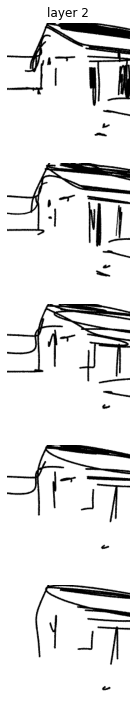

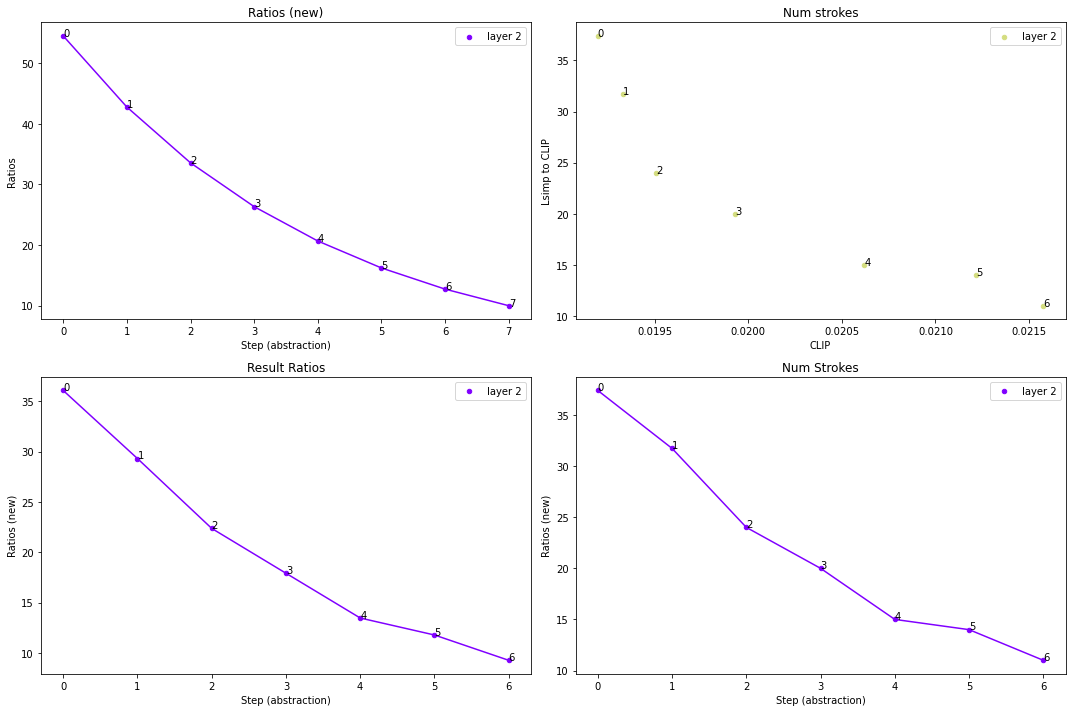

0 280 60 499
{}
16.633,8.914,4.777,2.56,1.372,0.735,0.394,0.211


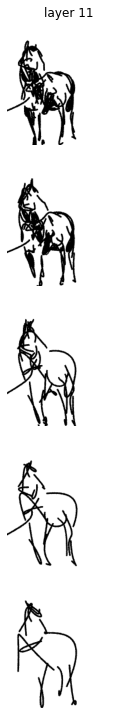

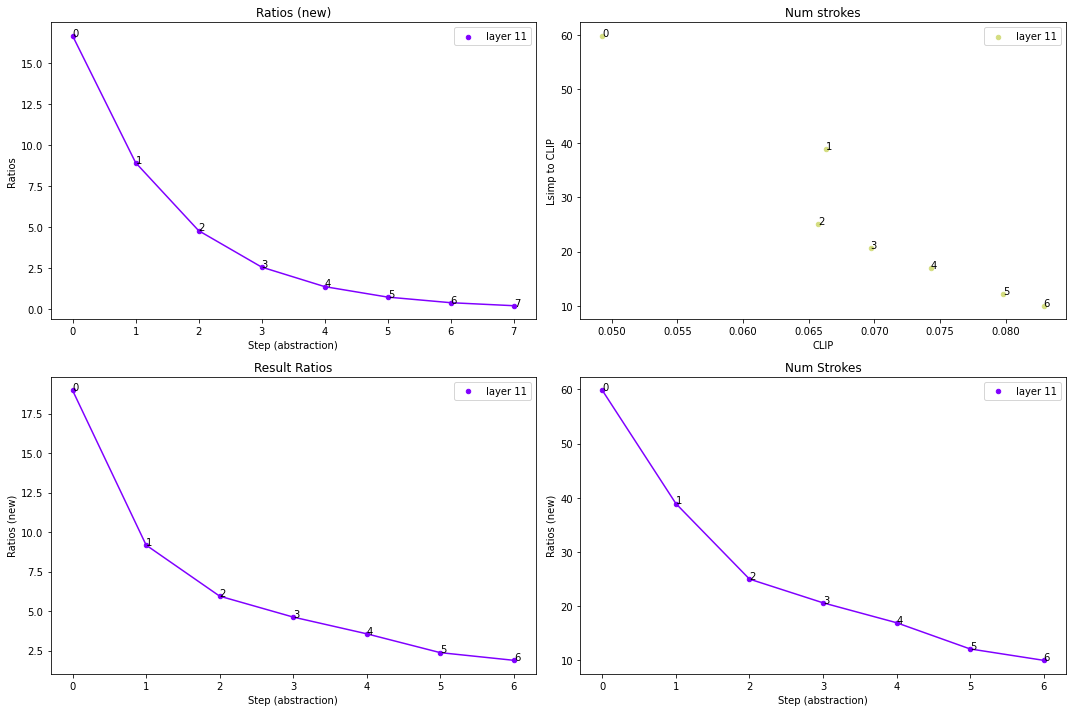

In [378]:
images=["semi-complex"]#, "ballerina"]
ratios_rel = [16,11.95,10.03,6.44,3.567,2.518,1.721,1.02]
rel_layer = 8
path_to_res = "/home/vinker/dev/background_project/experiements/ratio_09_10_fix3/"
path_to_initial_sketches = "/home/vinker/dev/background_project/experiements/all_together_09_09/"
    
object_or_background = "background"
layers = [2,7,8,11]
divs = [0.35,0.45,0.5,0.9]
layers = [2]
divs = [0.35]
draw_matrix_and_graphs(object_or_background, images, layers, path_to_res, rel_layer, ratios_rel, divs, step=2)

object_or_background = "object"
resize_obj = 1
layers = [2,7,8,11]
divs = [0.45,0.4,0.5,0.9]
layers = [11]
divs = [0.9]
draw_matrix_and_graphs(object_or_background, images, layers, path_to_res, rel_layer, ratios_rel, divs, step=2, resize_obj=resize_obj)

# 0.0479, 0.0479, 0.0465, 0.0466

In [324]:
def get_linear(ratios):
    r1 = ratios[0]
    clip_loss = 1 / r1
    num_s_new = 64
    step = 8
    linear_ratios = [r1]
    ri = r1
    for i in range(7):
        num_s_new = (num_s_new - step) 
        ri = (num_s_new / 64) / clip_loss
        linear_ratios.append(ri)
    return ratios_to_str(linear_ratios)



ratios2 = get_linear([34.479,27.052,21.225,16.652,13.065,10.251,8.043,6.31])
print(ratios2)

ratios7 = get_linear([28.736,21.036,15.399,11.273,8.252,6.041,4.422,3.237])
print(ratios7)

ratios8 = get_linear([16.661,11.781,8.331,5.891,4.165,2.945,2.083,1.473])
print(ratios8)

ratios11 = get_linear([5.242,2.809,1.505,0.807,0.432,0.232,0.124,0.067])
print(ratios11)


34.479,30.169,25.859,21.549,17.239,12.93,8.62,4.31
28.736,25.144,21.552,17.96,14.368,10.776,7.184,3.592
16.661,14.578,12.496,10.413,8.331,6.248,4.165,2.083
5.242,4.587,3.931,3.276,2.621,1.966,1.31,0.655


In [1]:
images=["bull"]
ratios_rel = [16,11.95,10.03,6.44,3.567,2.518,1.721,1.02]
rel_layer = 8
path_to_res = "/home/vinker/dev/background_project/experiements/ratio_05_10_fix2/"
path_to_initial_sketches = "/home/vinker/dev/background_project/experiements/all_together_09_09/"
    
object_or_background = "background"
layers = [2,7,8,11]
divs = [0.7,0.9,0.0,0.0]
# divs = [0.35,0.45,0.5,0.9]
draw_matrix_and_graphs(object_or_background, images, layers, path_to_res, rel_layer, ratios_rel, divs, step=1)

object_or_background = "object"
resize_obj = 1
layers = [2,7,8,11]
divs = [0.9,0.8,0.0,0.0]
# divs = [0.45,0.4,0.5,0.9]
draw_matrix_and_graphs(object_or_background, images, layers, path_to_res, rel_layer, ratios_rel, divs, step=1, resize_obj=1)

# 0.0479, 0.0479, 0.0465, 0.0466

NameError: name 'draw_matrix_and_graphs' is not defined

# Draw matrox no object seperation

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


None


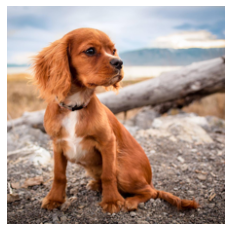

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


setting device
setting device


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


setting device
setting device


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


setting device
setting device


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


setting device
setting device


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


setting device


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


setting device


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


setting device


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


setting device
setting device
setting device


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


setting device


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


setting device


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


setting device
setting device


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


setting device
setting device


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


setting device
setting device


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


setting device
setting device


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


setting device
setting device


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


setting device
setting device


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


setting device
setting device


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


setting device
setting device


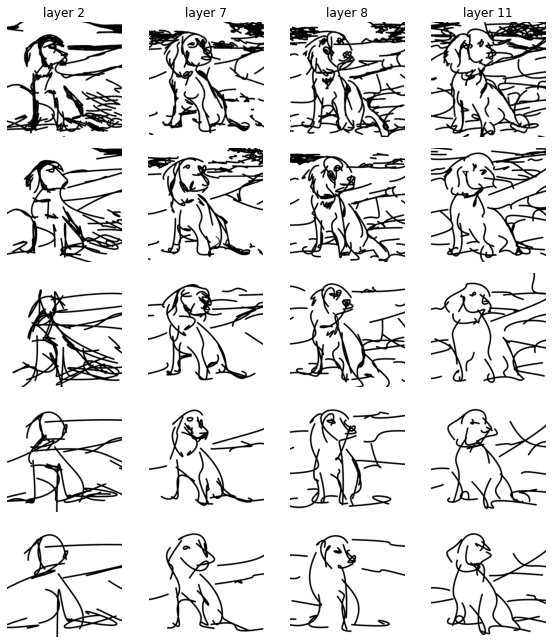

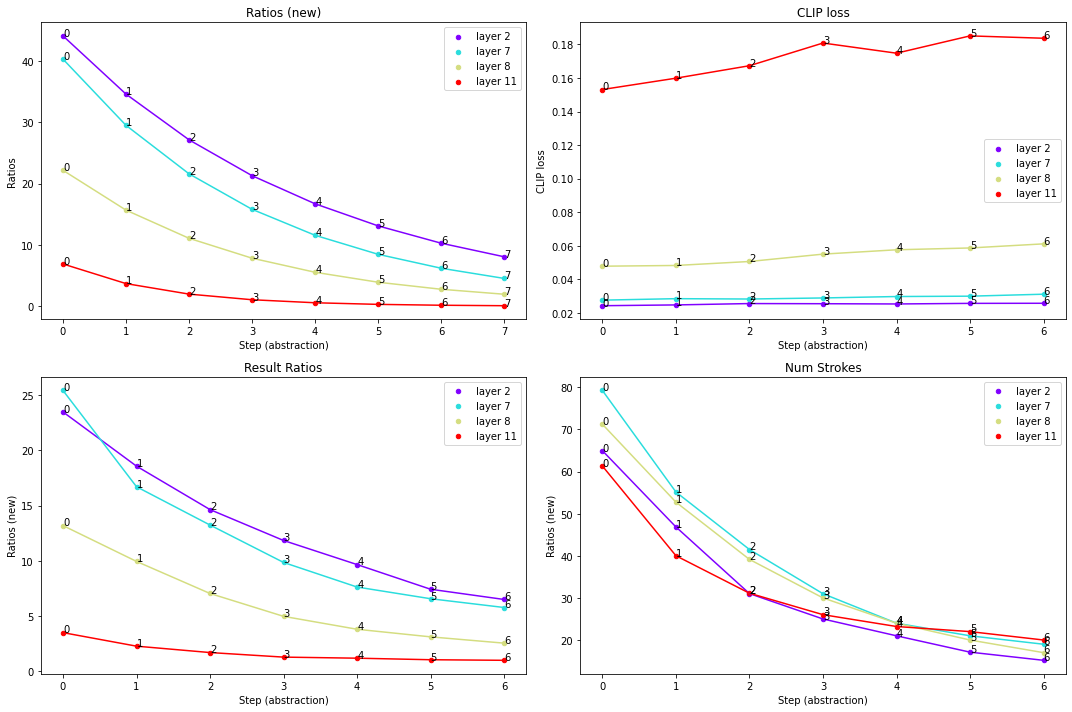

In [9]:
def draw_matrix_and_graphs(object_or_background, images, layers, path_to_res, rel_layer, ratios_rel, divs, step=1, resize_obj=0):
    final_ratio_per_l_per_im, final_num_s_per_l_per_im, ratios_dict_per_layer_per_im, clip_loss_dict_per_layer_per_im = init_dict(layers), init_dict(layers), init_dict(layers), init_dict(layers)

    for im_name_ in images:
        target_path = f"{path_to_files}/{im_name_}.jpg"
        target, mask, masked_target, original_mask, params = notebooks_utils.get_target(target_path, device, image_scale=224, resize_obj=resize_obj, return_params=resize_obj)
        print(params)
        plt.imshow(target[0].permute(1,2,0).cpu())
        plt.axis("off")
        plt.show()
        
        figa = plt.figure(figsize=(len(layers)*2, len(ratios_rel)*2))
        # figa = plt.figure(figsize=(7,10))
        for i, layer in enumerate(layers):
            path_to_res_ = path_to_res
            im_name = im_name_
            # if object_or_background == "background":
            #     im_name = f"{im_name_}_mask"
            res_filename = f"{object_or_background}_l{layer}_128s_{im_name}_resize{resize_obj}_combined"
            svg_filename = notebooks_utils.get_svg_path(f"{path_to_initial_sketches}/{res_filename}")
            path_svg = f"{path_to_initial_sketches}/{res_filename}/{svg_filename}"
            im = notebooks_utils.read_svg(path_svg, resize_obj=resize_obj, params=params)
            filename = f"{im_name}_layer{i}"
            imageio.imsave(f"{outputres_path}/{filename}.png", im)

            
           
            min_div = divs[i]
                
            # ratios_str = get_ratios_str(path_to_initial_sketches, rel_layer, folder_name_rel, folder_name_l, layer, ratios_rel, im_name, object_or_background,min_div)
            ratios_str = get_ratios_srt2(path_to_initial_sketches, res_filename, layer, im_name, object_or_background, min_div, num_ratios=8)
            # print(ratios_str)
            ratios = [float(item) for item in ratios_str.split(',')]
            ratios_dict_per_layer_per_im[layer][im_name] = ratios
            ratios = ratios[:10]
            # print(ratios)
            plt.subplot(len(ratios) + 1, len(layers), i + 1)
            plt.imshow(im)
            plt.title(f"layer {layer}")  
            plt.axis("off")
            
            ratios_res = []
            num_strokes_res = []
            clip_loss_res = []
            k = 0
            
            for j, r in enumerate(ratios[1:]):
                test_name_pref = f"l{layer}_128s_{im_name}_{min_div}_combined"
                
                
                # if resize_obj:
                #     test_name_pref += f"_resize{resize_obj}"
                res_filename = f"ratio{r}_{test_name_pref}"
                # path_res = f"{path_to_res_}/{res_filename}"
                # if not os.path.isdir(path_res):
                #     res_filename = f"{res_filename}_resize{resize_obj}"
                # print(res_filename)
                best_svg_filename = notebooks_utils.get_svg_path(f"{path_to_res_}/{res_filename}")
                path_best_im = f"{path_to_res_}/{res_filename}/{best_svg_filename}"
                im = notebooks_utils.read_svg(path_best_im, resize_obj=resize_obj, params=params, multiply=True)
                if j % step == 0:
                    plt.subplot(len(ratios) + 1, len(layers), (k + 1) * len(layers) + i + 1)
                    plt.imshow(im)
                    plt.axis("off")
                    k += 1
                    filename = f"{im_name}_row{j}col{i}"
                    imageio.imsave(f"{outputres_path}/{filename}.png", im)

                seed = notebooks_utils.get_seed(os.path.split(path_best_im)[-1])
                path_conf = f"{path_to_res_}/{res_filename}/{res_filename}_seed{seed}/config.npy"
                config = np.load(path_conf, allow_pickle=True)[()]

                loss_clip = np.array(config[f"clip_vit_l{layer}_original_eval"])
                loss_width = np.array(config["width_loss_original_eval"])
                best_iter = int(config["best_normalised_iter"] / config["eval_interval"])

                width_loss_ = loss_width[best_iter]
                clip_loss_ = loss_clip[best_iter]
                ratio = width_loss_ / clip_loss_
                ratios_res.append(ratio)

                num_strokes = np.array(config["num_strokes"])[best_iter].cpu()
                num_strokes_res.append(num_strokes)                
                clip_loss_res.append(clip_loss_)

            final_ratio_per_l_per_im[layer][im_name] = ratios_res
            final_num_s_per_l_per_im[layer][im_name] = num_strokes_res
            clip_loss_dict_per_layer_per_im[layer][im_name] = clip_loss_res

        plt.tight_layout()
        # plt.savefig(f"matrix_07_09/{im_name}.png")
        plt.show()
        plt.close()


    # plot graphs
    # for im_name in images:
        figa = plt.figure(figsize=(15,10))
        colors = cm.rainbow(np.linspace(0, 1, len(layers)))
        for i, layer in enumerate(layers):        
            ratios = ratios_dict_per_layer_per_im[layer][im_name]
            clip_loss = clip_loss_dict_per_layer_per_im[layer][im_name]
            ratios_res = final_ratio_per_l_per_im[layer][im_name]
            num_strokes_res = final_num_s_per_l_per_im[layer][im_name] 

            plt.subplot(2,2,1)
            draw_graph(ratios, layer, i, colors, "Ratios", "Step (abstraction)", "Ratios (new)")
            # print(f"layer {layer}, {ratios}")
            
            plt.subplot(2,2,2)
            draw_graph(clip_loss, layer, i, colors, "CLIP loss", "Step (abstraction)", "CLIP loss")

            plt.subplot(2,2,3)
            draw_graph(ratios_res, layer, i, colors, "Ratios (new)", "Step (abstraction)", "Result Ratios")

            plt.subplot(2,2,4)
            draw_graph(num_strokes_res, layer, i, colors, "Ratios (new)", "Step (abstraction)", "Num Strokes")
            
        plt.legend()
        plt.tight_layout()
        # plt.savefig(f"matrix_07_09/{im_name}_graph.png")
        plt.show()
        plt.close()

ratios_rel = [16,11.95,10.03,6.44,3.567,2.518,1.721,1.02]
rel_layer = 8
path_to_res = "/home/vinker/dev/background_project/experiements/ratio_09_10_fix3/"
path_to_initial_sketches = "/home/vinker/dev/background_project/experiements/all_together_09_09/"
object_or_background = "background"
outputres_path = "/home/vinker/dev/background_project/paper_results/ablation_obj_back_together"
# images=["house3"]#, "ballerina"]
# layers = [2,4,7,8,11]
# divs = [0.35,0.45,0.45,0.5,0.9]
# draw_matrix_and_graphs(object_or_background, images, layers, path_to_res, rel_layer, ratios_rel, divs, step=2)

images=["dog"]#, "ballerina"]
# divs = [1.0, 1.0, 1.0, 1.0, 1.0]
layers = [2,7,8,11]
divs = [0.35,0.45,0.5,0.9]
draw_matrix_and_graphs(object_or_background, images, layers, path_to_res, rel_layer, ratios_rel, divs, step=2)

# images=["bull"]#, "ballerina"]
# layers = [2,4,7,8,11]
# divs = [0.45,0.45,0.45,0.5,0.9]
# draw_matrix_and_graphs(object_or_background, images, layers, path_to_res, rel_layer, ratios_rel, divs, step=2)

# images=["woman_city"]#, "ballerina"]
# layers = [2,7,8,11]
# divs = [0.45,0.45,0.5,0.9]
# draw_matrix_and_graphs(object_or_background, images, layers, path_to_res, rel_layer, ratios_rel, divs, step=2)

# images=["man_flowers"]#, "dog", "basketball-5", "black_man"]#, "ballerina"]
# # layers = [2,3,4,5,6,7,8,11]
# # divs = [0.35,0.45,0.45,0.45,0.45,0.45,0.5,0.9]
# layers = [2,7,8,11]
# divs = [0.35,0.45,0.5,0.9]
# draw_matrix_and_graphs(object_or_background, images, layers, path_to_res, rel_layer, ratios_rel, divs, step=2)


# Draw combined matrix
    


1.0 0.0


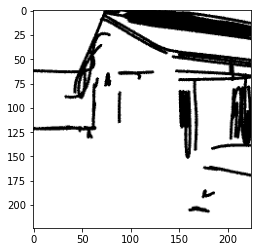

In [381]:
path_svg = "/home/vinker/dev/background_project/experiements/all_together_09_09//background_l2_64s_semi-complex_mask/background_l2_64s_semi-complex_mask_seed1000_best.svg"
im = notebooks_utils.read_svg(path_svg, resize_obj=0, params=None)
print(im.max(), im.min())
# imageio.imsave("im.png",im)
plt.imshow(im)
plt.show()

In [312]:
def get_matrix(im_name, layers, object_or_background, divs, path_to_res, path_to_initial_sketches, resize_obj=0, params=None):
    matrix = []
    op = 1
    if object_or_background == "background":
        im_name = f"{im_name}_mask"
        op = 0.7
        op = 1
        
    for i, layer in enumerate(layers):
        sketches_col = []
        res_filename = f"{object_or_background}_l{layer}_64s_{im_name}"
        if resize_obj:
            res_filename += f"_resize{resize_obj}"
        path_res = f"{path_to_initial_sketches}/{res_filename}"
        if not os.path.isdir(path_res):
            res_filename = f"{res_filename}_resize{resize_obj}"
        svg_filename = notebooks_utils.get_svg_path(f"{path_to_initial_sketches}/{res_filename}")
        path_svg = f"{path_to_initial_sketches}/{res_filename}/{svg_filename}"
        sketch = notebooks_utils.read_svg(path_svg, resize_obj=resize_obj, params=params, opacity=op)
        # sketches_col.append(sketch)
        
        # folder_name_rel = f"{object_or_background}_l{rel_layer}_64s_{im_name}"
        # if resize_obj:
        #     folder_name_rel += f"_resize{resize_obj}"
        folder_name_l = res_filename#f"{object_or_background}_l{layer}_64s_{im_name}"
        min_div = divs[i]
        ratios_str = get_ratios_srt2(path_to_initial_sketches, folder_name_l, layer, im_name, object_or_background, min_div, num_ratios=8)
        # ratios_str = get_ratios_str(path_to_initial_sketches, rel_layer, folder_name_rel, folder_name_l, 
        #                             layer, ratios_rel, im_name, object_or_background, min_div, prevseed=False)
        # print(ratios_str)
        ratios = [float(item) for item in ratios_str.split(',')]

        ratios_res = []
        num_strokes_res = []
        
        k = 0
        for j, r in enumerate(ratios):
            test_name_pref = f"l{layer}_64s_{im_name}_{min_div}"
            if resize_obj:
                test_name_pref += f"_resize{resize_obj}"
            path_res = f"{path_to_res}/{res_filename}"
            if not os.path.isdir(path_res):
                res_filename = f"{res_filename}_resize{resize_obj}"
            res_filename = f"ratio{r}_{test_name_pref}"
            best_svg_filename = notebooks_utils.get_svg_path(f"{path_to_res}/{res_filename}")
            path_best_im = f"{path_to_res}/{res_filename}/{best_svg_filename}"
            sketch = notebooks_utils.read_svg(path_best_im, resize_obj=resize_obj, params=params, opacity=op)
            sketches_col.append(sketch)
        matrix.append(sketches_col)

    matrix = np.array(matrix)
    return matrix


def draw_matrix(matrix_back, matrix_obj, mask_np):
    mean_over_rows = matrix_back.mean(axis=0)

    figa = plt.figure(figsize=(int(matrix_back.shape[0] * 2), int(matrix_back.shape[1] * 2)))
    for layer_index in range(matrix_back.shape[0]):
        k = 0
        for ratio_index in range(matrix_back.shape[1]):
            if ratio_index % 2 == 0:
                mean_back = mean_over_rows[ratio_index]
                back_cur = matrix_back[layer_index, ratio_index]
                back_cur_op, mean_back_op = 1 - back_cur, 1 - mean_back 
                # back_blend = 0.5 * back_cur_op + 0.5 * mean_back_op
                back_blend = 1 * back_cur_op
                back_blend = 1 - back_blend
                back_blend[mask_np == 1] = 1

                obj_cur = matrix_obj[layer_index, ratio_index]
                obj_cur_op = (1 - obj_cur)
                back_blend_op = (1 - back_blend) #* 0.7
                back_blend_op[obj_cur_op > 0.0] = 1 * obj_cur_op[obj_cur_op > 0.0]
                # back_blend = 1 - back_blend_op
                im_blend = 1 - back_blend_op
                plt.subplot(matrix_back.shape[1], matrix_back.shape[0], (k) * matrix_back.shape[0] + layer_index + 1)
                plt.imshow(im_blend)
                plt.axis("off")
                k += 1
    plt.tight_layout()
    plt.show()
    plt.close()



960 2699 204 3839


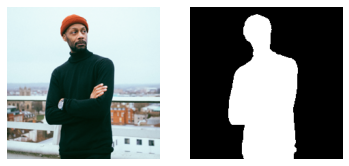

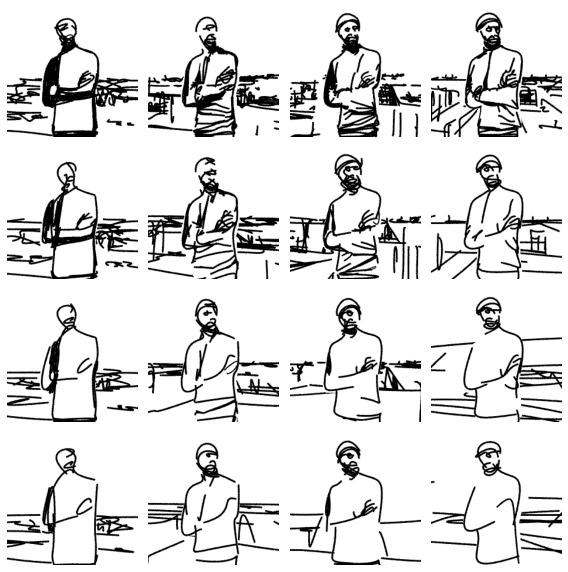

In [313]:
path_to_initial_sketches = "/home/vinker/dev/background_project/experiements/all_together_09_09/"
path_to_res = "/home/vinker/dev/background_project/experiements/ratio_09_10_fix3/"
# images = ["basketball-5", "man_camera", "house3", "house4", "ballerina", "black_woman"]#"bull", "panda", "man_flowers", "van"]
images = ["black_man"]#,"bull"]#basketball-5", "man_flowers", "man_camera", "house3", "house4", "ballerina"]
# images = ["man_flowers"]
resize_obj = 1
for im_name in images:
    target_path = f"{path_to_files}/{im_name}.jpg"
    target, mask, masked_target, original_mask, params = notebooks_utils.get_target(target_path, device, image_scale=224, resize_obj=resize_obj, return_params=resize_obj)
    # target, mask, maske_target = notebooks_utils.get_target(target_path, device, image_scale=224)
    mask_np = original_mask[0].permute(1,2,0).cpu().numpy()
    plt.subplot(1,2,1)
    plt.imshow(target[0].permute(1,2,0).cpu())
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(mask_np)
    plt.axis("off")
    plt.show()
    plt.close()
    
    layers = [2,7,8,11]
    divs = [0.35,0.45,0.5,0.9]
    matrix_back = get_matrix(im_name, layers, "background", divs, path_to_res, path_to_initial_sketches, resize_obj=0, params=params)
    layers = [2,7,8,11]
    divs = [0.45,0.4,0.5,0.9]
    matrix_obj = get_matrix(im_name, layers, "object", divs, path_to_res, path_to_initial_sketches, resize_obj=resize_obj, params=params)
    
    draw_matrix(matrix_back, matrix_obj, mask_np)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


tensor(1., device='cuda:0') tensor(0.3122, device='cuda:0')
29 424 75 462


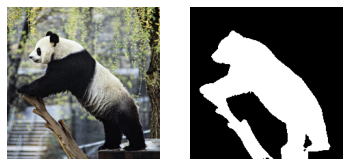

FileNotFoundError: [Errno 2] No such file or directory: '/home/vinker/dev/background_project/experiements/ratio_09_10_fix3//ratio12.492_l11_64s_panda_0.9_resize1_resize1'

In [12]:
def get_matrix(im_name, layers, object_or_background, divs, path_to_res, path_to_initial_sketches, resize_obj=0, params=None, save_png=False, outputres_path=None):
    matrix = []
    matrix_names = []
    op = 1
    if object_or_background == "background":
        im_name = f"{im_name}_mask"
        op = 1
        # op = 0.5
        
    for i, layer in enumerate(layers):
        sketches_col = []
        names_col = []
        res_filename = f"{object_or_background}_l{layer}_64s_{im_name}"
        if resize_obj:
            res_filename += f"_resize{resize_obj}"
        path_res = f"{path_to_initial_sketches}/{res_filename}"
        if not os.path.isdir(path_res):
            res_filename = f"{res_filename}_resize{resize_obj}"
            path_res = f"{path_to_initial_sketches}/{res_filename}"
        svg_filename = notebooks_utils.get_svg_path(path_res)
        path_svg = f"{path_to_initial_sketches}/{res_filename}/{svg_filename}"
        sketch = notebooks_utils.read_svg(path_svg, resize_obj=resize_obj, params=params, opacity=op, multiply=save_png)
        # if save_png:   
        #     shutil.copyfile(path_svg, f"{outputres_path}/{res_filename}.svg")
            # imageio.imsave(f"{outputres_path}/{res_filename}.png", sketch)
            
        # sketches_col.append(sketch)
        
        folder_name_l = res_filename
        min_div = divs[i]
        ratios_str = get_ratios_srt2(path_to_initial_sketches, folder_name_l, layer, im_name, object_or_background, min_div, num_ratios=8)
        # print(ratios_str)
        ratios = [float(item) for item in ratios_str.split(',')]

        ratios_res = []
        num_strokes_res = []
        
        k = 0
        for j, r in enumerate(ratios):
            test_name_pref = f"l{layer}_64s_{im_name}_{min_div}"
            if resize_obj:
                test_name_pref += f"_resize{resize_obj}"
            res_filename = f"ratio{r}_{test_name_pref}"
            path_res = f"{path_to_res}/{res_filename}"
            if not os.path.isdir(path_res):
                res_filename = f"{res_filename}_resize{resize_obj}"
                path_res = f"{path_to_res}/{res_filename}"
            best_svg_filename = notebooks_utils.get_svg_path(f"{path_res}")
            path_best_im = f"{path_to_res}/{res_filename}/{best_svg_filename}"
            sketch = notebooks_utils.read_svg(path_best_im, resize_obj=resize_obj, params=params, opacity=op, multiply=save_png)
            sketches_col.append(sketch)
            names_col.append(res_filename)
            # if save_png:  
            #     shutil.copyfile(path_svg, f"{outputres_path}/{res_filename}.svg")
                # imageio.imsave(f"{outputres_path}/{res_filename}.png", sketch)
        matrix.append(sketches_col)
        names_col.append(names_col)

    matrix = np.array(matrix)
    return matrix

def draw_matrix(matrix_back, matrix_obj, mask_np, save_png=False, outputres_path=None, im_name=None):
    mean_over_rows = matrix_back.mean(axis=0)
    
    if save_png:
        mask_np = resize(mask_np, (mask_np.shape[0] * 2, mask_np.shape[1] * 2), order=0)
    
    figa = plt.figure(figsize=(int(matrix_back.shape[0] * 2), int(matrix_back.shape[1] * 2)))
    step = 1
    for layer_index in range(matrix_back.shape[0]):
        k = 0
        
        for ratio_index in range(matrix_back.shape[1]):
            if ratio_index % step == 0:
                mean_back = mean_over_rows[ratio_index]
                back_cur = matrix_back[layer_index, ratio_index]
                back_cur_op, mean_back_op = 1 - back_cur, 1 - mean_back 
                # back_blend = 0.5 * back_cur_op + 0.5 * mean_back_op
                back_blend = 1 * back_cur_op
                back_blend = 1 - back_blend
                im_blend = back_blend
                if matrix_obj is not None:
                    back_blend[mask_np == 1] = 1
                    obj_cur = matrix_obj[layer_index, ratio_index]
                    obj_cur_op = (1 - obj_cur)
                    back_blend_op = (1 - back_blend)# * 0.7
                    back_blend_op[obj_cur_op > 0.0] = 1 * obj_cur_op[obj_cur_op > 0.0]
                    # back_blend = 1 - back_blend_op
                    im_blend = 1 - back_blend_op
                plt.subplot(matrix_back.shape[1], matrix_back.shape[0], (k) * matrix_back.shape[0] + layer_index + 1)
                plt.imshow(im_blend)
                plt.axis("off")
                
                if save_png:
                    r_i = int(ratio_index / step)
                    filename = f"{im_name}_row{r_i}col{layer_index}_black"
                    # str_overleaf = "\\frame{{\\includegraphics[width=0.1025\\textwidth,height=0.1025\\textwidth]{{figs/matrices/{}.png}}}}"
                    # if k % 3 == 0 and k > 0:
                    #     print(str_overleaf.format(filename) + " \\\\\n")
                    # else:
                    #     print(str_overleaf.format(filename) + " &")
                    im_blend = ((im_blend / im_blend.max()) * 255).astype(np.uint8)
                    imageio.imsave(f"{outputres_path}/{filename}.png", im_blend)
                k += 1
    plt.tight_layout()
    plt.show()
    plt.close()
    
def print_overleaf(im_name):
    for ratio_index in range(4):
        for layer_index in range(4):
            filename = f"{im_name}_row{ratio_index}col{layer_index}_black"
            str_overleaf = "\\frame{{\\includegraphics[width=0.1025\\textwidth,height=0.1025\\textwidth]{{figs/matrices/{}.png}}}}"
            if layer_index % 3 == 0 and layer_index > 0:
                print(str_overleaf.format(filename) + " \\\\\n")
            else:
                print(str_overleaf.format(filename) + " &")

# Draw matric and save results
output_path = "/home/vinker/dev/background_project/paper_results/matrices"
path_to_initial_sketches = "/home/vinker/dev/background_project/experiements/all_together_09_09/"
path_to_res = "/home/vinker/dev/background_project/experiements/ratio_09_10_fix3/"
# images = ["basketball-5", "man_camera", "house3", "house4", "ballerina", "black_woman"]#"bull", "panda", "man_flowers", "van"]
images = ["panda"]#, "house3", "man_flowers"]#, "house4"]#"ballerina", "man_flowers"]

resize_obj = 1
save_png=False
for im_name in images:
    
    target_path = f"{path_to_files}/{im_name}.jpg"
    target, mask, masked_target, original_mask, params = notebooks_utils.get_target(target_path, device, image_scale=224, resize_obj=resize_obj, return_params=resize_obj)
    # target, mask, maske_target = notebooks_utils.get_target(target_path, device, image_scale=224)
    mask_np = original_mask[0].permute(1,2,0).cpu().numpy()
    plt.subplot(1,2,1)
    plt.imshow(target[0].permute(1,2,0).cpu())
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(mask_np)
    plt.axis("off")
    plt.show()
    plt.close()
    
    layers = [2,7,8,11]
    divs = [0.35,0.45,0.5,0.9]
    matrix_back = get_matrix(im_name, layers, "background", divs, path_to_res, path_to_initial_sketches, resize_obj=0, params=params, save_png=save_png, outputres_path=output_path)
    layers = [2,7,8,11]
    divs = [0.45,0.4,0.5,0.9]
    matrix_obj = get_matrix(im_name, layers, "object", divs, path_to_res, path_to_initial_sketches, resize_obj=resize_obj, params=params, save_png=save_png, outputres_path=output_path)
    matrix_obj = None
    draw_matrix(matrix_back, matrix_obj, mask_np, save_png=save_png, outputres_path=output_path, im_name=im_name)
    # print_overleaf(im_name)

# play with the ratios defenition

In [23]:
def get_ratios_rel(popt, path_to_res, im_name_, ratios_rel, rel_layer):
    start_ys, start_x, end_x_addition = 0, 0, 0
    popt = get_func(ratios_rel, start_x, start_ys)
    if object_or_background == "object":
        start_x = -2
    if object_or_background == "background":
        start_x = -1
    # get the first value in the relative layer, sampled from the new function
    step_size = 1
    num_steps = len(ratios_rel) - start_x
    start_ = start_x
    end = len(ratios_rel)
    x_new_ = np.linspace(start_, end - step_size, num_steps)
    y_new_ = func(x_new_, *popt)
    return y_new_

def get_ratios_stepsize(y_new_, div1, min_div, start_x, end_x_addition):
    scale_layer = y_new_[0] / div1
    scale_layer_copy = scale_layer
    ratios_rel_cur = [scale_layer]
    for i in range(4):
        scale_layer = scale_layer / 2
        ratios_rel_cur.append(scale_layer)
    popt = get_func(ratios_rel_cur, start_x=0, start_ys=0)
    
    x_value = func_inv([scale_layer_copy], *popt)
    div = min(div1, 1.8) # only relevant for layer 11, where the jump is too high 
    if min_div:
        div = max(div1, min_div) # only relevant for layer 11, where the jump is too high 
    print(f"layer[{layer}] org_div[{div1:.3f}] div[{div:.3f}]")
    step_size = div / 2
    num_steps = len(ratios_rel) - start_x + end_x_addition
    start_ = x_value[0]
    end = num_steps * step_size
    # sample the function from the initial scaled r_1 with the corresponding step size
    new_xs_layer_l = np.linspace(start_, end - step_size + start_, num_steps) 
    # print("new_xs_layer_l", new_xs_layer_l)
    ratios_li = func(new_xs_layer_l, *popt)
    return ratios_li
    

def get_div(path_to_res, im_name_, object_or_background, rel_layer):
    path_to_res_ = path_to_res
    im_name = im_name_
    if object_or_background == "background":
        im_name = f"{im_name_}_mask"
    
    folder_name_rel = f"{object_or_background}_l{rel_layer}_64s_{im_name}"
    folder_name_l = f"{object_or_background}_l{layer}_64s_{im_name}"
    
    svg_filename = notebooks_utils.get_svg_path(f"{path_to_initial_sketches}/{folder_name_l}")
    seed = notebooks_utils.get_seed(svg_filename)
    # print(svg_filename, "seed", seed)
    path_li = f"{path_to_initial_sketches}/{folder_name_l}/{folder_name_l}_seed{seed}"
    best_iter, loss_clip_layer = get_clip_loss(path_li, layer, object_or_background)
    best_lclip_layer = loss_clip_layer[best_iter]
    # print("best_iter", best_iter, "best_lclip_layer", best_lclip_layer)
    
    # getting the scaling factor among different layers of CLIP

    svg_filename = notebooks_utils.get_svg_path(f"{path_to_initial_sketches}/{folder_name_rel}")
    seed = notebooks_utils.get_seed(svg_filename)
    path_l_rel = f"{path_to_initial_sketches}/{folder_name_rel}/{folder_name_rel}_seed{seed}"
    best_iter_rel, loss_clip_layer_rel = get_clip_loss(path_l_rel, rel_layer, object_or_background)
    best_lclip_layer_rel = loss_clip_layer_rel[best_iter_rel]    
    div1 = best_lclip_layer / best_lclip_layer_rel 
    
    return div1

def get_div_1(folder_name_l, object_or_background, layer):
    svg_filename = notebooks_utils.get_svg_path(f"{path_to_initial_sketches}/{folder_name_l}")
    seed = notebooks_utils.get_seed(svg_filename)
    path_li = f"{path_to_initial_sketches}/{folder_name_l}/{folder_name_l}_seed{seed}"
    best_iter, loss_clip_layer = get_clip_loss(path_li, layer, object_or_background)
    best_lclip_layer = loss_clip_layer[best_iter]
    # print(best_lclip_layer)
    div1 = 1 / best_lclip_layer 
    return div1
    


/home/miniconda/envs/habitat/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/miniconda/envs/habitat/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/miniconda/envs/habitat/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/miniconda/envs/habitat/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


========== layer 2 ============
r_1_k 34.47930708829307 [34.47930709 27.05191605 21.22450315 16.65240766 13.06521424 10.25075933
  8.04258276  6.31008254]
========== layer 7 ============
r_1_k 28.736296235078957 [28.73629624 21.03620014 15.39939986 11.27302053  8.25233405  6.04106212
  4.42231632  3.23732503]
========== layer 8 ============
r_1_k 16.661419136997864 [16.66141914 11.78140246  8.33070957  5.89070123  4.16535478  2.94535061
  2.08267739  1.47267531]
========== layer 11 ============
r_1_k 5.242301299083156 [5.2423013  2.80927971 1.50545572 0.80675374 0.43232863 0.23167917
 0.1241538  0.06653237]


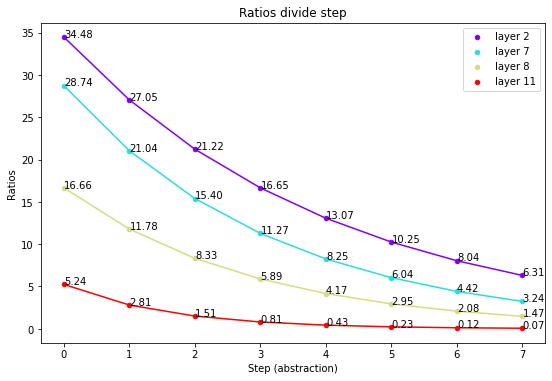

In [25]:
im_name_="man_flowers"
object_or_background = "background"
resize_obj = 0
step_sizes = [0.7 / 2, 0.9 / 2, 0.5, 1.8 / 2]
# object_or_background = "object"
# resize_obj = 1

# step_sizes = [0.9 / 2, 0.8 / 2, 0.5, 1.8 / 2]
# divs = [0.7,0.9,0,0]
num_ratios = 8
layers = [2,7,8,11]
start_x ,end_x_addition = 0, 0

figa = plt.figure(figsize=(15,10))
colors = cm.rainbow(np.linspace(0, 1, len(layers)))

for i, layer in enumerate(layers):
    step_size_l = step_sizes[i]
    im_name = im_name_
    if object_or_background == "background":
        im_name = f"{im_name_}_mask"
    
    res_filename = f"{object_or_background}_l{layer}_64s_{im_name}"
    if resize_obj:
        res_filename += f"_resize{resize_obj}"
    
    svg_filename = notebooks_utils.get_svg_path(f"{path_to_initial_sketches}/{res_filename}")
    
    # this is r_1_k = 1 / clip_k
    r_1_k = get_div_1(res_filename, object_or_background, layer)
    # print(r_1_k)
    r_j_k = r_1_k
    ratios_k = [r_1_k]
    for j in range(4):
        r_j_k = r_j_k / 2
        ratios_k.append(r_j_k)
    popt = get_func(ratios_k, start_x=0, start_ys=0) # fit the function to ratios_k
    x_1_k = func_inv([r_1_k], *popt)

    step_size = step_size_l
    num_steps = num_ratios - start_x + end_x_addition
    start_ = x_1_k[0]
    end = num_steps * step_size
    # sample the function from the initial scaled r_1 with the corresponding step size
    new_xs_layer_l = np.linspace(start_, end - step_size + start_, num_steps) 
    # print("new_xs_layer_l", new_xs_layer_l)
    ratios_li = func(new_xs_layer_l, *popt)
    print(f"========== layer {layer} ============")
    print(f"r_1_k {r_1_k} {ratios_li}")
    plt.subplot(2,2,3)
    draw_graph(ratios_li, layer, i, colors, "Ratios", "Step (abstraction)", "Ratios divide step")
    
plt.legend()
plt.tight_layout()
# plt.savefig(f"matrix_07_09/{im_name}_graph.png")
plt.show()
plt.close()

/home/miniconda/envs/habitat/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/miniconda/envs/habitat/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/miniconda/envs/habitat/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/miniconda/envs/habitat/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/miniconda/envs/habitat/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/miniconda/envs/habitat/lib/python3.7/site-packages/scipy/optimize/min

layer[2] org_div[0.268] div[0.700]
layer[7] org_div[0.583] div[0.900]
layer[8] org_div[1.000] div[1.000]
layer[11] org_div[3.115] div[1.800]


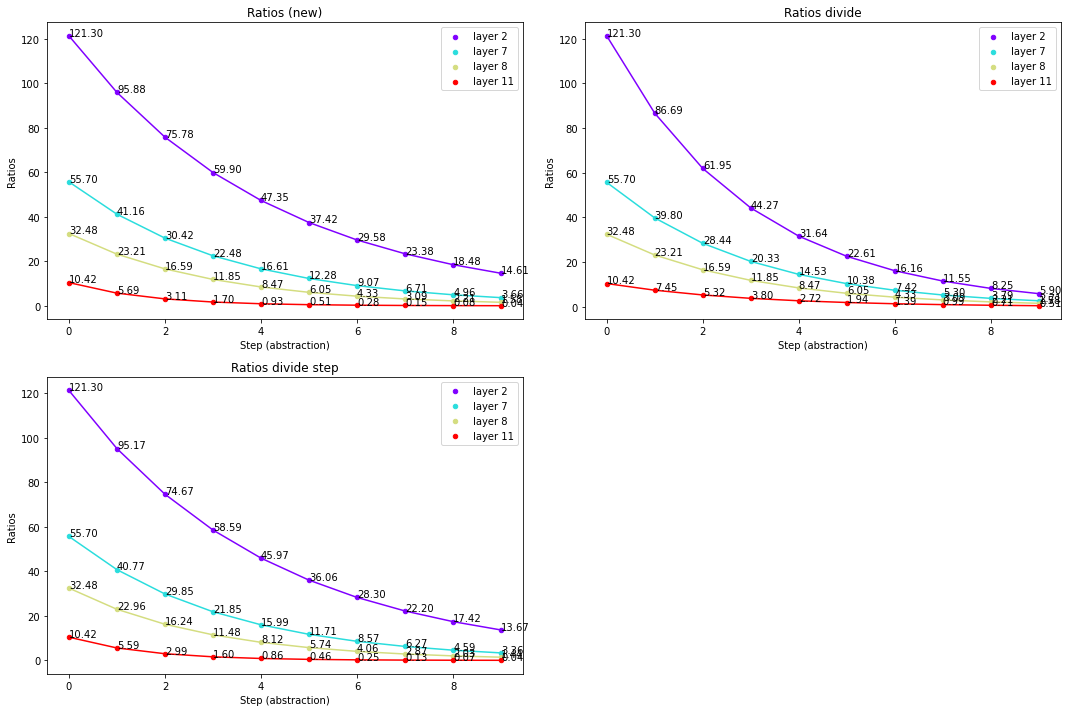

In [27]:
# get the ratios
ratios_rel_new = [16,11.95,10.03,6.44,3.567,2.518,1.721,1.02]
rel_layer_new = 8

im_name_="man_flowers"
# im_name_="semi-complex"
object_or_background = "object"
start_x = -1
end_x_addition = 0
divs = [0.7,0.9,0,0]
layers = [2,7,8,11]
# divs = [0]
# layers = [8]

figa = plt.figure(figsize=(15,10))
colors = cm.rainbow(np.linspace(0, 1, len(layers)))
for i, layer in enumerate(layers):
    m_div = divs[i]
    im_name = im_name_
    if object_or_background == "background":
        im_name = f"{im_name_}_mask"
    
    res_filename = f"{object_or_background}_l{layer}_64s_{im_name}"
    svg_filename = notebooks_utils.get_svg_path(f"{path_to_initial_sketches}/{res_filename}")

    folder_name_rel = f"{object_or_background}_l{rel_layer_new}_64s_{im_name}"
    folder_name_l = f"{object_or_background}_l{layer}_64s_{im_name}"
    seed = notebooks_utils.get_seed(svg_filename)
    
    ratios_str = get_ratios_str(path_to_initial_sketches, rel_layer_new, folder_name_rel, folder_name_l, layer, ratios_rel_new, im_name, object_or_background, min_div=m_div)
    ratios_reg = [float(item) for item in ratios_str.split(',')]
    plt.subplot(2,2,1)
    draw_graph(ratios_reg, layer, i, colors, "Ratios", "Step (abstraction)", "Ratios (new)")
    
    start_ys, start_x, end_x_addition = 0, 0, 0
    popt = get_func(ratios_rel_new, start_x, start_ys)
    ratios_rel = get_ratios_rel(popt, path_to_res, im_name_, ratios_rel_new, rel_layer)
    div1 = get_div(path_to_res, im_name_, object_or_background, rel_layer)
    ratios_div = ratios_rel / div1
    plt.subplot(2,2,2)
    draw_graph(ratios_div, layer, i, colors, "Ratios", "Step (abstraction)", "Ratios divide")
    
    ratios_step = get_ratios_stepsize(ratios_rel, div1, m_div, start_x, end_x_addition)
    plt.subplot(2,2,3)
    draw_graph(ratios_step, layer, i, colors, "Ratios", "Step (abstraction)", "Ratios divide step")
    
plt.legend()
plt.tight_layout()
# plt.savefig(f"matrix_07_09/{im_name}_graph.png")
plt.show()
plt.close()

In [26]:
scale_layer = 23.21
scale_layer_copy = scale_layer
ratios_rel_cur = [scale_layer]
min_div = 0
div1 = 1
for i in range(4):
    scale_layer = scale_layer / 2
    ratios_rel_cur.append(scale_layer)
print(ratios_rel_cur)
popt = get_func(ratios_rel_cur, start_x=0, start_ys=0)
x_value = func_inv([scale_layer_copy], *popt)

div = min(div1, 1.8) # only relevant for layer 11, where the jump is too high 
if min_div:
    div = max(div1, min_div) # only relevant for layer 11, where the jump is too high 
print(f"layer[{layer}] org_div[{div1:.3f}] div[{div:.3f}]")
step_size = div / 2
num_steps = len(ratios_rel) - start_x + end_x_addition
start_ = x_value[0]
end = num_steps * step_size
# sample the function from the initial scaled r_1 with the corresponding step size
new_xs_layer_l = np.linspace(start_, end - step_size + start_, num_steps) 
# print("new_xs_layer_l", new_xs_layer_l)
ratios_li = func(new_xs_layer_l, *popt)
print(ratios_li)

[23.21, 11.605, 5.8025, 2.90125, 1.450625]
layer[11] org_div[1.000] div[1.000]
[23.21       16.41194839 11.605       8.2059742   5.8025      4.1029871
  2.90125     2.05149355]


/home/miniconda/envs/habitat/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


# plot ablation ratios

In [379]:
def draw_matrix_and_graphs(object_or_background, images, layers, path_to_res, rel_layer, ratios_all, divs, step=1, resize_obj=0):
    final_ratio_per_l_per_im, final_num_s_per_l_per_im, ratios_dict_per_layer_per_im, clip_loss_dict_per_layer_per_im = init_dict(layers), init_dict(layers), init_dict(layers), init_dict(layers)

    for im_name_ in images:
        target_path = f"{path_to_files}/{im_name_}.jpg"
        target, mask, masked_target, original_mask, params = notebooks_utils.get_target(target_path, device, image_scale=224, resize_obj=resize_obj, return_params=resize_obj)
        print(params)
        
        figa = plt.figure(figsize=(len(layers)*2, len(ratios_rel)*2))
        # figa = plt.figure(figsize=(7,10))
        for i, layer in enumerate(layers):
            path_to_res_ = path_to_res
            im_name = im_name_
            if object_or_background == "background":
                im_name = f"{im_name_}_mask"
            res_filename = f"{object_or_background}_l{layer}_64s_{im_name}"
            if resize_obj:
                res_filename += f"_resize{resize_obj}"
            path_res = f"{path_to_initial_sketches}/{res_filename}"
            if not os.path.isdir(path_res):
                res_filename = f"{res_filename}_resize{resize_obj}"
            svg_filename = notebooks_utils.get_svg_path(f"{path_to_initial_sketches}/{res_filename}")
            path_svg = f"{path_to_initial_sketches}/{res_filename}/{svg_filename}"
            im = notebooks_utils.read_svg(path_svg, resize_obj=resize_obj, params=params)
            
            folder_name_rel = f"{object_or_background}_l{rel_layer}_64s_{im_name}"
            if resize_obj:
                folder_name_rel += f"_resize{resize_obj}"
            folder_name_l = res_filename#f"{object_or_background}_l{layer}_64s_{im_name}"
            
            min_div = divs[i]
                
            # ratios_str = get_ratios_str(path_to_initial_sketches, rel_layer, folder_name_rel, folder_name_l, layer, ratios_rel, im_name, object_or_background,min_div)
            # ratios_str = get_ratios_srt2(path_to_initial_sketches, folder_name_l, layer, im_name, object_or_background, min_div, num_ratios=8)
            # ratios_str = ["16.661","14.491","12.322","10.152","7.982","5.812,3.643,1.473]
            # print(ratios_str)
            ratios = ratios_all[i]
            ratios_dict_per_layer_per_im[layer][im_name] = ratios
            ratios = ratios[:7]
            # print(ratios)
            plt.subplot(len(ratios) + 1, len(layers), i + 1)
            plt.imshow(im)
            plt.title(f"layer {layer}")  
            plt.axis("off")
            
            ratios_res = []
            num_strokes_res = []
            clip_loss_res = []
            k = 0
            
            for j, r in enumerate(ratios):
                test_name_pref = f"l{layer}_64s_{im_name}_same8"
                if resize_obj:
                    test_name_pref += f"_resize{resize_obj}"
                res_filename = f"ratio{r}_{test_name_pref}"
                path_res = f"{path_to_res_}/{res_filename}"
                if not os.path.isdir(path_res):
                    res_filename = f"{res_filename}_resize{resize_obj}"
                # print(res_filename)
                best_svg_filename = notebooks_utils.get_svg_path(f"{path_to_res_}/{res_filename}")
                path_best_im = f"{path_to_res_}/{res_filename}/{best_svg_filename}"
                im = notebooks_utils.read_svg(path_best_im, resize_obj=resize_obj, params=params)
                if j % step == 0:
                    plt.subplot(len(ratios) + 1, len(layers), (k + 1) * len(layers) + i + 1)
                    plt.imshow(im)
                    plt.axis("off")
                    k += 1

                seed = notebooks_utils.get_seed(os.path.split(path_best_im)[-1])
                path_conf = f"{path_to_res_}/{res_filename}/{res_filename}_seed{seed}/config.npy"
                config = np.load(path_conf, allow_pickle=True)[()]

                loss_clip = np.array(config[f"clip_vit_l{layer}_original_eval"])
                loss_width = np.array(config["width_loss_original_eval"])
                best_iter = int(config["best_normalised_iter"] / config["eval_interval"])

                width_loss_ = loss_width[best_iter]
                clip_loss_ = loss_clip[best_iter]
                ratio = width_loss_ / clip_loss_
                ratios_res.append(ratio)

                num_strokes = np.array(config["num_strokes"])[best_iter].cpu()
                num_strokes_res.append(num_strokes)                
                clip_loss_res.append(clip_loss_)

            final_ratio_per_l_per_im[layer][im_name] = ratios_res
            final_num_s_per_l_per_im[layer][im_name] = num_strokes_res
            clip_loss_dict_per_layer_per_im[layer][im_name] = clip_loss_res

        plt.tight_layout()
        # plt.savefig(f"matrix_07_09/{im_name}.png")
        plt.show()
        plt.close()


    # plot graphs
    # for im_name in images:
        figa = plt.figure(figsize=(15,10))
        colors = cm.rainbow(np.linspace(0, 1, 8))
        for i, layer in enumerate(layers):        
            ratios = ratios_dict_per_layer_per_im[layer][im_name]
            clip_loss = clip_loss_dict_per_layer_per_im[layer][im_name]
            ratios_res = final_ratio_per_l_per_im[layer][im_name]
            num_strokes_res = final_num_s_per_l_per_im[layer][im_name] 

            plt.subplot(2,2,1)
            draw_graph(ratios, layer, i, colors, "Ratios", "Step (abstraction)", "Ratios (new)")
            # print(f"layer {layer}, {ratios}")
            
            plt.subplot(2,2,2)
            # draw_graph(clip_loss, layer, i, colors, "Ratios", "Step (abstraction)", "CLIP loss", label="target ratios")
            draw_graph(num_strokes_res, layer, i + 2, colors, "Lsimp to CLIP", "CLIP", "Num strokes", x_vals=clip_loss)
            # draw_graph(ratios, layer, i, colors, "Ratios", "Step (abstraction)", "Ratios", label="target ratios")
            # draw_graph(ratios_res, layer, i + 2, colors, "Ratios", "Step (abstraction)", "Ratios", label="result ratios")

            plt.subplot(2,2,3)
            draw_graph(ratios_res, layer, i, colors, "Ratios (new)", "Step (abstraction)", "Result Ratios")

            plt.subplot(2,2,4)
            draw_graph(num_strokes_res, layer, i, colors, "Ratios (new)", "Step (abstraction)", "Num Strokes")
            
            
        plt.legend()
        plt.tight_layout()
        # plt.savefig(f"matrix_07_09/{im_name}_graph.png")
        plt.show()
        plt.close()

None


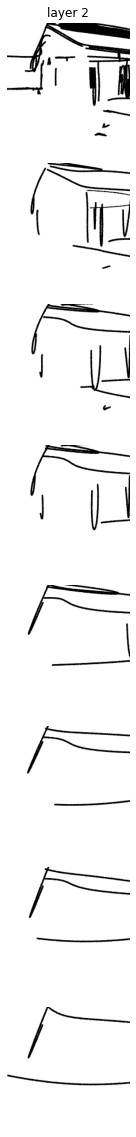

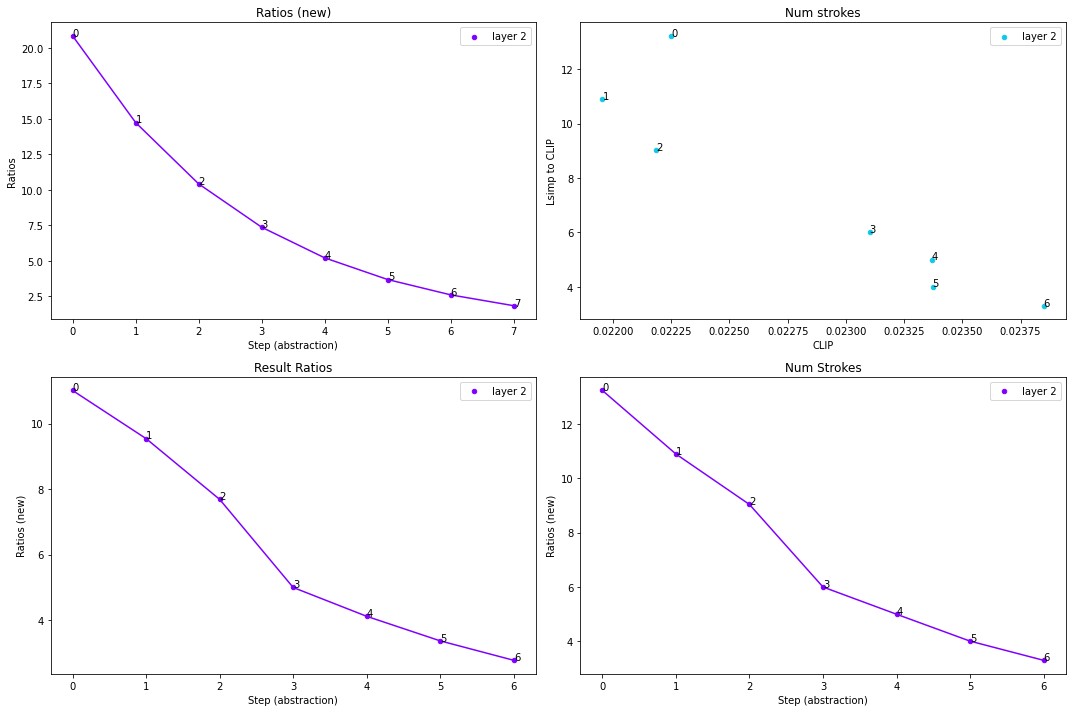

In [380]:
images=["semi-complex"]#, "ballerina"]
ratios_rel = [16,11.95,10.03,6.44,3.567,2.518,1.721,1.02]
rel_layer = 8
path_to_res = "/home/vinker/dev/background_project/experiements/ablation_ratios_13_10/"
path_to_initial_sketches = "/home/vinker/dev/background_project/experiements/all_together_09_09/"
    
object_or_background = "background"
# layers = [2,7,8,11]
# divs = [0.35,0.45,0.5,0.9]
layers = [2]
divs = [0.35]
# ratios = [[34.479,30.455,26.431,22.407,18.382,14.358,10.334,6.31],
#           [28.736,25.093,21.451,17.808,14.165,10.522,6.88,3.237],
#             [16.661,14.491,12.322,10.152,7.982,5.812,3.643,1.473],
#          [5.242,4.503,3.763,3.024,2.285,1.546,0.806,0.067]]
ratios = [[20.839,14.736,10.42,7.368,5.21,3.684,2.605,1.842]]
draw_matrix_and_graphs(object_or_background, images, layers, path_to_res, rel_layer, ratios, divs, step=1)
# draw_matrix_and_graphs(object_or_background, images, layers[3:4], path_to_res, rel_layer, ratios[3:4], divs[3:4], step=2)


None


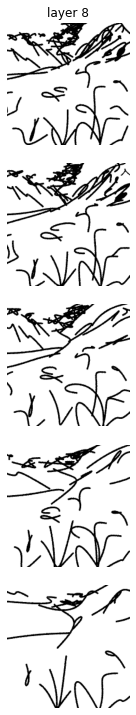

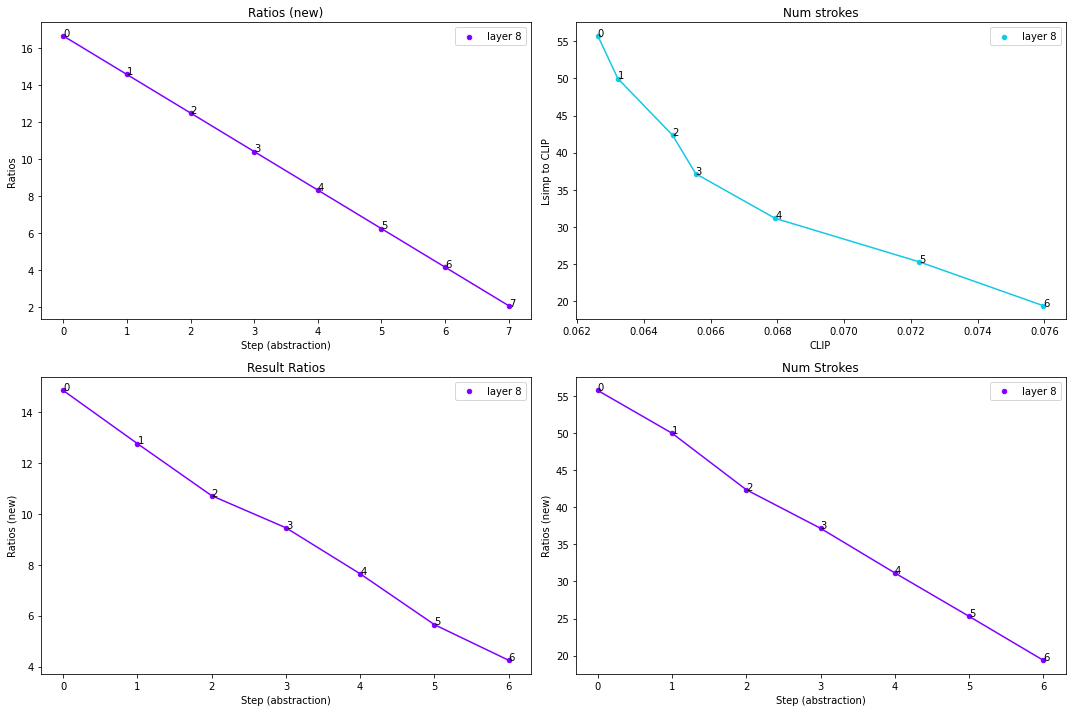

None


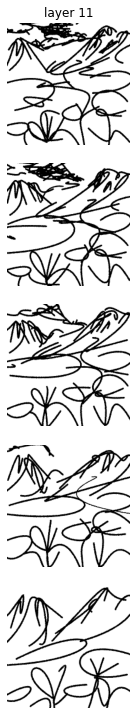

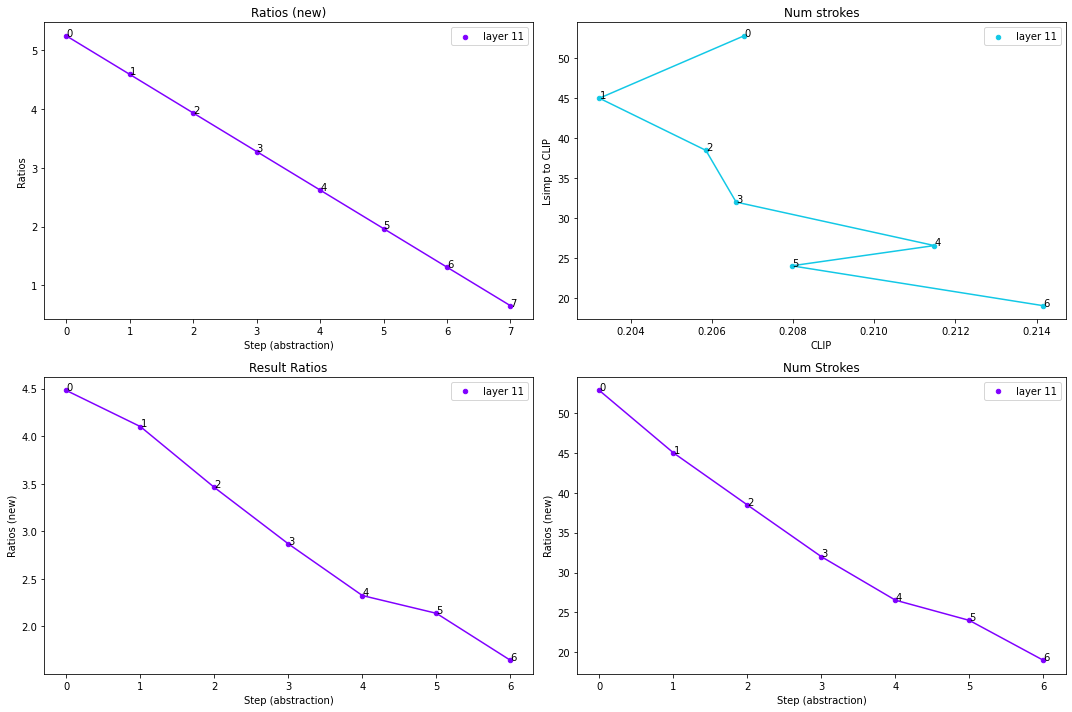

In [370]:
images=["man_flowers"]#, "ballerina"]
ratios_rel = [16,11.95,10.03,6.44,3.567,2.518,1.721,1.02]
rel_layer = 8
path_to_res = "/home/vinker/dev/background_project/experiements/ablation_ratios_13_10/"
path_to_initial_sketches = "/home/vinker/dev/background_project/experiements/all_together_09_09/"
    
object_or_background = "background"
# layers = [2,7,8,11]
# divs = [0.35,0.45,0.5,0.9]
layers = [2, 7, 8, 11]
divs = [0.35, 0.5,0.5, 0.9]
# ratios = [[34.479,30.455,26.431,22.407,18.382,14.358,10.334,6.31],
#           [28.736,25.093,21.451,17.808,14.165,10.522,6.88,3.237],
#             [16.661,14.491,12.322,10.152,7.982,5.812,3.643,1.473],
#          [5.242,4.503,3.763,3.024,2.285,1.546,0.806,0.067]]
ratios = [[34.479,30.169,25.859,21.549,17.239,12.93,8.62,4.31],
          [28.736,25.144,21.552,17.96,14.368,10.776,7.184,3.592],
            [16.661,14.578,12.496,10.413,8.331,6.248,4.165,2.083],
         [5.242,4.587,3.931,3.276,2.621,1.966,1.31,0.655]]
draw_matrix_and_graphs(object_or_background, images, layers[2:3], path_to_res, rel_layer, ratios[2:3], divs[2:3], step=2)
draw_matrix_and_graphs(object_or_background, images, layers[3:4], path_to_res, rel_layer, ratios[3:4], divs[3:4], step=2)

# object_or_background = "object"
# resize_obj = 1
# layers = [2,7,8,11]
# divs = [0.45,0.4,0.5,0.9]
# # layers = [11]
# # divs = [0.9]
# draw_matrix_and_graphs(object_or_background, images, layers, path_to_res, rel_layer, ratios_rel, divs, step=2, resize_obj=resize_obj)
